# Prediction Module

    The main goal of the prediction module is to use the PropaPhenKG+ and the observations found in the detection module to cluster the observations into similar phenomenon clusters

In [1]:
%load_ext autoreload
%autoreload 2

## Libraries

### Installing

In [2]:
#!pip install pandas
#!pip install tqdm
#!pip install -U scikit-learn
#!pip install matplotlib

### Standard

In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import glob

### Custom libraries

## Globals

In [4]:
path_to_kb_gazetteer = "../Detection/data/gazetteers/kbgazetteer.csv"
path_to_netwoork_gazetteer = "../Detection/data/gazetteers/world_gazetteer.csv"
path_to_observationcsv = "../Detection/data/csv/observations_phrase.csv"
path_to_worldkg_nodes = "../Description/data/worldkg_nodes.csv"

In [5]:

path_to_journalobservationcsv = "../data/neo4j/observations_journal.csv"
path_to_medicalobservationcsv = "../data/neo4j/observations_medical.csv"
path_to_socialobservationcsv = "../data/neo4j/observations_social.csv"

## Observation Embedding

    It should get the observations and the PropaPhenKG+ to transform the observations into observation vectors

### Loading Observations

In [6]:
df_observations_journal = pd.read_csv(path_to_journalobservationcsv)
df_observations_medical = pd.read_csv(path_to_medicalobservationcsv)
df_observations_social = pd.read_csv(path_to_socialobservationcsv)
df_observations_journal['System_Name'] = 'Journal_' + df_observations_journal['System_Name'].astype(str)
df_observations_medical['System_Name'] = 'Medical_' + df_observations_medical['System_Name'].astype(str)
df_observations_social['System_Name'] = 'Social_' + df_observations_social['System_Name'].astype(str)

In [7]:
df_observations = pd.concat([df_observations_journal,df_observations_medical], ignore_index=True)
df_observations = pd.concat([df_observations,df_observations_social], ignore_index=True)

In [8]:
df_observations

,Unnamed: 0,System_Name,n.id,c.name,c.id,intensity
0,0,"Journal_""China""",wkg:424313582,"['Genus: Coronavirus', 'virus', 'host', 'year'...","['A23448874', 'A4387104', 'A18644523', 'A71838...","[6, 14, 5, 5, 6, 7, 6, 6, 6, 6, 9, 14, 6, 7, 7..."
1,1,"Journal_""India""",wkg:424314145,"['viruses', 'viruses', 'bat', 'recent', 'state...","['A18631884', 'A8396339', 'A18627674', 'A18692...","[16, 16, 6, 6, 5, 5, 5, 5, 6, 14, 6, 5, 9, 13,..."
2,2,"Journal_""Japan""",wkg:424313451,"['CDISC ADAS-Cog - Orientation: Date', 'CDISC ...","['C3639227', 'A21413049']","[6, 6]"
3,3,"Journal_""United States""",wkg:424317935,"['University', 'University', 'University', 'ne...","['A2887795', 'A0130305', 'A10762625', 'A185809...","[5, 5, 5, 5]"
4,0,"Medical_""Canada""",wkg:424313760,['CDISC ADAS-Cog - Naming Objects and Fingers:...,"['A21402131', 'C0332281', 'A26673288', 'A31804...","[13, 7, 7, 7, 6, 6, 13, 17, 7, 6, 6, 6, 6, 7, ..."
...,...,...,...,...,...,...
57,34,"Social_""Ukraine""",wkg:1648342273,['CDISC ADAS-Cog - Naming Objects and Fingers:...,"['A21402131', 'C3639180', 'A7883147']","[20, 20, 30]"
58,35,"Social_""United Kingdom""",wkg:838090640,"['Times', 'woman', '6', '6', 'confirmed', 'via...","['A19654950', 'A18631976', 'A8317211', 'C53999...","[25, 28, 26, 26, 24, 33, 39, 54, 29, 25, 33, 3..."
59,36,"Social_""United States""",wkg:424317935,['CDISC ADAS-Cog - Naming Objects and Fingers:...,"['A21401148', 'C1561579', 'A20948640', 'A00775...","[97, 90, 37, 23, 24, 47, 201, 39, 29, 27, 23, ..."
60,37,"Social_""Venezuela""",wkg:424311890,['CDISC ADAS-Cog - Naming Objects and Fingers:...,"['A21419034', 'A0320232', 'A8312915', 'A328107...","[21, 25, 21, 21, 21, 25, 29, 21, 21, 21, 21]"


In [9]:
def obsToList(obs,isint=False):
    newlist = list([x.replace("'",'') for x in
        map(str.strip, obs.strip('][').replace('"', '').replace('"', "").split(','))])
    if isint:
        return [int(x) for x in newlist]
    else:
        return newlist

In [10]:
def getTopMax(df_observations, top=10):    
    for index, row in df_observations.iterrows():
        newsort_value = []
        newsort_names = []
        newsort_id = []
        for (x,y,z) in zip( obsToList(row['c.id']),obsToList(row['intensity'],True),obsToList(row['c.name'])):
            if z not in newsort_names:
                newsort_names.append(z)
                newsort_value.append(y)
                newsort_id.append(x)
        newsort_names = [x for _, x in sorted(zip(newsort_value, newsort_names ))]
        newsort_id = [x for _, x in sorted(zip(newsort_value, newsort_id ))]
        newsort_value.sort()
        df_observations.at[index,'c.id'] = str(newsort_id[-min(top,len(newsort_id)):])
        df_observations.at[index,'intensity'] = str(newsort_value[-min(top,len(newsort_id)):])
        df_observations.at[index,'c.name'] = str(newsort_names[-min(top,len(newsort_id)):])
    return df_observations

In [11]:
df_observations = getTopMax(df_observations,top=25)

In [12]:
pd.set_option('display.max_rows', None)
len(obsToList(df_observations.at[27,'c.name']))

25

In [13]:
df_observations.at[27,'c.name']

"['CDISC ADAS-Cog - Naming Objects and Fingers: 8', 'Yersinia enterocolitica serogroup O:8', 'CDISC ADAS-Cog - Naming Objects and Fingers: 4', 'www', 'Flu', 'amp', 'CDISC ADAS-Cog - Naming Objects and Fingers: 5', 'CDISC ADAS-Cog - Naming Objects and Fingers: 1', 'Boucher JL. Nutrition care for hospitalized individuals with diabetes. Diabetes Spectrum 2005;18:34-38. Available at: http://spectrum.diabetesjournals.org/cgi/content/full/18/1/34 . Accessed July 29', 'outbreak', 'Coronavirus', 'Genus: Coronavirus', 'new', 'Chinese', 'Race: Chinese', 'CDISC ADAS-Cog - Naming Objects and Fingers: 2', 'cases', 'Source: Swift CS', 'Animal inoculation: virus', 'people', 'virus', 'https://github.com/geneontology/go-ontology/issues/22888', 'comments', 'coronavirus', 'Yersinia enterocolitica serogroup O:19']"

In [14]:
obs_dict = {}
obs_set = set([])
for index, row in df_observations.iterrows():
    obs_dict[row['System_Name']] = obsToList(row['c.name'])
    obs_set = obs_set.union(set(obs_dict[row['System_Name']]))
place_set = list(obs_dict.keys())

### Embeddings

In [15]:
class ObservationEmbedding():
    
    def __init__(self, obs_dict):
        self.obs_dict = obs_dict
        
    def binaryDictionaryEmbedding(self, dict_kb):
        obs_matrix = np.zeros((len(obs_dict.keys()),len(dict_kb)))
        for system in self.obs_dict.keys():
            for kb_item in obs_dict[system]:
                obs_matrix[dict_net[system],dict_kb[kb_item]] = 1
        return obs_matrix

In [16]:
dict_kb = dict(zip(list(obs_set),range(len(obs_set))))

In [17]:
dict_net = dict(zip(list(df_observations['System_Name']),range(len(place_set))))

In [18]:
#import sys
#print("The size of the variable is:",sys.getsizeof(obs_matrix), "bytes.")

In [19]:
obsEmbedding = ObservationEmbedding(obs_dict)

In [20]:
embeddingMatrix = obsEmbedding.binaryDictionaryEmbedding(dict_kb)

### Connection to Neo4j

## Observation Clustering
    It should get the observation vectors and transform them into Phenomenon Cluster

In [21]:
class ObservationClustering():
    
    def __init__(self, embeddingMatrix=None):
        self.embeddingMatrix = embeddingMatrix
        
    def KMeans(self,nb_clusters,random_state=0,n_init="auto"):
        return KMeans(n_clusters=nb_clusters, random_state=random_state, n_init=n_init).fit(self.embeddingMatrix)
    
    def plot(self, legend_list, labels, apply_pca=False,apply_tsne=True, pca_random_state=1):
        if apply_pca:
            pca = PCA(2, random_state=pca_random_state)
            matrix = pca.fit_transform(self.embeddingMatrix)
        elif apply_tsne:
            tsne = TSNE(n_components=2, random_state=pca_random_state)
            matrix = tsne.fit_transform(self.embeddingMatrix)
        else:
            matrix = self.embeddingMatrix
        u_labels = np.unique(labels)
        for i in u_labels:
            plt.scatter(matrix[labels == i , 0] , matrix[labels == i , 1] , label = i)
        # Label points
        for (i,j, legend) in zip(matrix[:,0], matrix[:,1],legend_list):
            plt.text(i, j, legend)
        plt.legend()
        plt.show()
    
    def smartPrint(self, np_obslist, labels):
        u_labels = np.unique(labels)
        print('Clusters:')
        for i in range(len(u_labels)):
            print("clusters : " + str(u_labels[i]))
            print(np_obslist[labels==u_labels[i]])

In [22]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [23]:
#list_indexes = list(range(embeddingMatrix.shape[0]))
list_indexes = [0,5,27,1,15,33]

In [24]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
matrix = tsne.fit_transform(embeddingMatrix)
obsClusteringModule = ObservationClustering(matrix[list_indexes])

In [25]:
kmeans = obsClusteringModule.KMeans(2,random_state=9)

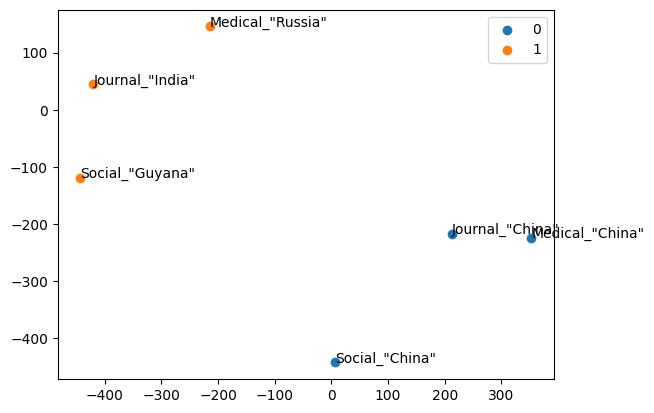

In [26]:
obsClusteringModule.plot(np.array(list(df_observations['System_Name']))[list_indexes],kmeans.labels_,
                         apply_tsne=False )

In [27]:
obsClusteringModule.smartPrint(df_observations['System_Name'].to_numpy()[list_indexes],kmeans.labels_)

Clusters:
clusters : 0
['Journal_"China"' 'Medical_"China"' 'Social_"China"']
clusters : 1
['Journal_"India"' 'Medical_"Russia"' 'Social_"Guyana"']


In [28]:
from scipy import spatial

In [29]:
from sklearn.metrics.pairwise import cosine_similarity

In [34]:
list_indexes = list(range(embeddingMatrix.shape[0]))

In [35]:
print(list_indexes)
print(df_observations['System_Name'].to_numpy()[list_indexes])
distanceMatrix = np.zeros((len(list_indexes),len(list_indexes)))
for x in range(len(list_indexes)):
    for y in range(len(list_indexes)):
        distanceMatrix[x,y] = cosine_similarity(embeddingMatrix[list_indexes[x],:].reshape(1, -1)
                                                ,embeddingMatrix[list_indexes[y],:].reshape(1, -1))[0,0]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]
['Journal_"China"' 'Journal_"India"' 'Journal_"Japan"'
 'Journal_"United States"' 'Medical_"Canada"' 'Medical_"China"'
 'Medical_"Djibouti"' 'Medical_"France"' 'Medical_"Germany"'
 'Medical_"Ghana"' 'Medical_"Iran"' 'Medical_"Iraq"' 'Medical_"Ireland"'
 'Medical_"Italy"' 'Medical_"Portugal"' 'Medical_"Russia"'
 'Medical_"Saudi Arabia"' 'Medical_"South Korea"' 'Medical_"Spain"'
 'Medical_"Turkey"' 'Medical_"Ukraine"' 'Medical_"United Kingdom"'
 'Medical_"United States"' 'Social_"Argentina"' 'Social_"Australia"'
 'Social_"Belgium"' 'Social_"Canada"' 'Social_"China"' 'Social_"Ethiopia"'
 'Social_"France"' 'Social_"Germany"' 'Social_"Greece"' 'Social_"Guinea"'
 'Social_"Guyana"' 'Social_"India"' 'Social_"Indonesia"' 'Social_"Iran"'
 'Social_"Ireland"' 'So

In [36]:
df_cosinus_distance = pd.DataFrame(distanceMatrix, index=df_observations['System_Name'].to_numpy()[list_indexes],
                                   columns=df_observations['System_Name'].to_numpy()[list_indexes])

In [37]:
df_cosinus_distance

,"Journal_""China""","Journal_""India""","Journal_""Japan""","Journal_""United States""","Medical_""Canada""","Medical_""China""","Medical_""Djibouti""","Medical_""France""","Medical_""Germany""","Medical_""Ghana""",...,"Social_""South Korea""","Social_""Spain""","Social_""Sweden""","Social_""Switzerland""","Social_""Taiwan""","Social_""Ukraine""","Social_""United Kingdom""","Social_""United States""","Social_""Venezuela""","Social_""Vietnam"""
"Journal_""China""",1.000000,0.047140,0.0,0.000000,0.000000,0.188562,0.000000,0.000000,0.0,0.000000,...,0.068041,0.000000,0.000000,0.000000,0.000000,0.000000,0.141421,0.188562,0.000000,0.210819
"Journal_""India""",0.047140,1.000000,0.0,0.000000,0.000000,0.120000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.040000,0.000000,0.000000
"Journal_""Japan""",0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"Journal_""United States""",0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.141421,0.000000,0.000000,0.000000
"Medical_""Canada""",0.000000,0.000000,0.0,0.000000,1.000000,0.133333,0.000000,0.235702,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.235702,0.133333,0.066667,0.000000,0.149071
"Medical_""China""",0.188562,0.120000,0.0,0.000000,0.133333,1.000000,0.000000,0.141421,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.141421,0.160000,0.120000,0.000000,0.268328
"Medical_""Djibouti""",0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"Medical_""France""",0.000000,0.000000,0.0,0.000000,0.235702,0.141421,0.000000,1.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.141421,0.070711,0.000000,0.158114
"Medical_""Germany""",0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"Medical_""Ghana""",0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,...,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [66]:
from scipy.spatial import distance

distanceMatrix = np.zeros((len(list_indexes),len(list_indexes)))

list_indexes = list(range(embeddingMatrix.shape[0]))

for x in range(len(list_indexes)):
    for y in range(len(list_indexes)):
        distanceMatrix[x,y] = distance.euclidean(matrix[list_indexes[x],:]
                                                ,matrix[list_indexes[y],:])

In [67]:
df_euclidian_distance = pd.DataFrame(distanceMatrix, index=df_observations['System_Name'].to_numpy()[list_indexes],
                                   columns=df_observations['System_Name'].to_numpy()[list_indexes])
npchina = df_euclidian_distance[df_euclidian_distance.index == 'Journal_"China"'].to_numpy()

In [68]:
n = 62

In [69]:
df_journal_china = df_euclidian_distance[df_euclidian_distance.index == 'Journal_"China"'
                     ][ df_observations['System_Name'].to_numpy()[
    list(npchina.argsort()[0,:n])]]
for index, row in df_journal_china.iterrows():
    for key in row.keys():
        print(key + ' : '+ str(row[key]))

Journal_"China" : 0.0
Medical_"Saudi Arabia" : 114.28895568847656
Social_"Iran" : 126.44182586669922
Medical_"China" : 140.1909942626953
Social_"United Kingdom" : 147.58416748046875
Medical_"Iran" : 171.58863830566406
Social_"Russia" : 180.172119140625
Social_"Ukraine" : 183.30386352539062
Social_"India" : 212.54539489746094
Social_"Switzerland" : 212.54539489746094
Medical_"Djibouti" : 217.93701171875
Social_"Guinea" : 240.33567810058594
Social_"Venezuela" : 240.33567810058594
Social_"Argentina" : 256.703857421875
Social_"Mexico" : 277.60980224609375
Medical_"Iraq" : 281.10101318359375
Social_"Italy" : 291.2946472167969
Social_"China" : 305.79998779296875
Medical_"South Korea" : 309.76080322265625
Social_"North Korea" : 309.76080322265625
Social_"Ireland" : 312.9369201660156
Social_"Malaysia" : 312.9369201660156
Social_"Australia" : 312.9369201660156
Social_"Netherlands" : 312.9369201660156
Social_"Nigeria" : 312.9369201660156
Social_"Norway" : 312.9369201660156
Social_"Indonesia" : 3

## Neo4j Theta Evaluation

In [ ]:
import sys
sys.path.append('../Detection/lib/')
from lib.kgce.schema.semantic.neo4jclasses import Neo4jRelation
from lib.kgce.neo4j.handler import Neo4jWrapper

In [38]:
from neo4j import GraphDatabase
from tqdm import tqdm


class Neo4jWrapper:

    def __init__(self, uri, userName, password):
        self.uri = uri
        self.userName = userName
        self.password = password
        # Connect to the neo4j database server
        self.graphDB_Driver  = GraphDatabase.driver(uri, auth=(userName, password)) 
        
    def sendQuery(self, cql_commands):
        result = []
        done_queries = []
        with self.graphDB_Driver.session() as graphDB_Session:
            for cqlCreate in tqdm(cql_commands):
                try:
                    result += [graphDB_Session.run(cqlCreate).to_df()]
                    done_queries.append(cqlCreate)
                except Exception as e:
                    tqdm.write(str(e))
                    tqdm.write(cqlCreate)
                    result += [str(e)]
        return result
    
    def closeConnection(self):
        self.graphDB_Driver.close()

In [39]:
neowrapper = Neo4jWrapper(uri="bolt://localhost:7687",userName="neo4j",password="test")

In [45]:
def OldTheta(nodeid1, nodeid2,dictPath,neowrapper):
    # If calculated return
    if (nodeid1, nodeid2) in dictPath:
        return dictPath[(nodeid1, nodeid2)],dictPath
    elif nodeid1 == nodeid2:
        dictPath[(nodeid1, nodeid2)] = 0
        return dictPath[(nodeid1, nodeid2)], dictPath
    else:
        querystr = """MATCH (c1:UMLS|id:"{0}"\),(c2:UMLS|id:"{1}"\), 
            p = shortestPath((c1)-[*]-(c2))
            RETURN length(p) as value""".format(
            nodeid1,nodeid2).replace(
            "|","{").replace("\\","}")
        result = neowrapper.sendQuery([
            querystr
        ])
        value = const_max_path
        if(not result[0].empty):
            value = int(result[0]['value'].iloc[0])
        dictPath[(nodeid1, nodeid2)] = value
        return value, dictPath

In [46]:
const_max_path = 3263433+2 # All Node from CUI + 2 for the leaf AUI nodes
def Theta(nodeid1, nodeid2,dictPath,neowrapper):
    # If calculated return
    if (nodeid1, nodeid2) in dictPath:
        return dictPath[(nodeid1, nodeid2)],dictPath
    elif nodeid1 == nodeid2:
        dictPath[(nodeid1, nodeid2)] = 0
        return dictPath[(nodeid1, nodeid2)], dictPath
    else:
        querystr = """MATCH p=allShortestPaths((c1:UMLS|id:"{0}"\)-[*]-(c2:UMLS|id:"{1}"\))
        WHERE NONE(n in nodes(p) where ("SemanticType" in labels(n)) or 
                       (NOT "UMLS" in labels(n)))
        RETURN distinct length(p) as value""".format(
            nodeid1,nodeid2).replace(
            "|","{").replace("\\","}")
        result = neowrapper.sendQuery([
            querystr
        ])
        value = const_max_path
        if(not result[0].empty):
            value = int(result[0]['value'].iloc[0])
        dictPath[(nodeid1, nodeid2)] = value
        return value, dictPath

In [47]:
df_result = df_observations[['System_Name','c.id']]

In [48]:
country_measure = []
dictPath = {}

In [49]:
count = 0
for index, row in df_result.iterrows():
    print(row['System_Name'])
    # For each country
    for umlsel in obsToList(row['c.id']):
        # For each umls entity
        count += 1
        theta,dictPath = Theta(umlsel,'C5203670',dictPath,neowrapper)
        print(theta)

Journal_"China"


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.17s/it]


5


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.97s/it]


4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.63s/it]


3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.90s/it]


5


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.67s/it]


3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.64s/it]


4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.57s/it]


3263435


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.53s/it]


3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.66s/it]


3263435


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.30s/it]


3263435


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.58s/it]


3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.81s/it]


4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.62s/it]


3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.31s/it]


3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.64s/it]


3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.45s/it]


4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.62s/it]


3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.41s/it]


3
Journal_"India"


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.31s/it]


3263435


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.79s/it]


3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.60s/it]


3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.15s/it]


3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.63s/it]


3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.62s/it]


3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.77s/it]


6


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.90s/it]


5


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.63s/it]


3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.75s/it]


3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.55s/it]


4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.67s/it]


4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.26s/it]


4
3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.93s/it]


3263435


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.93s/it]


4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.43s/it]


3263435


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.51s/it]


4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.47s/it]


4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.03s/it]


3263435


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.52s/it]


3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.48s/it]


3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.43s/it]


3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.65s/it]


4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.48s/it]


3
Journal_"Japan"


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.81s/it]


3
Journal_"United States"


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.61s/it]


5


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.52s/it]


3
Medical_"Canada"


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.46s/it]


4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.16s/it]


5


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.49s/it]


4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.44s/it]


3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.59s/it]


4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.56s/it]


3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.53s/it]


3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.85s/it]


4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.80s/it]


3
Medical_"China"


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.57s/it]


3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.56s/it]


4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.77s/it]


3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.42s/it]


3263435


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.24s/it]


4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.97s/it]


3263435


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.44s/it]


3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.44s/it]


3263435


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.58s/it]


4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.43s/it]


3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.48s/it]


5


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.89s/it]


5
3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.43s/it]


3263435


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.07s/it]


3
3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.93s/it]


4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.02s/it]


3263435


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.59s/it]


4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.42s/it]


3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.72s/it]


4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.46s/it]


3263435


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.46s/it]


3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.64s/it]


3
4
Medical_"Djibouti"


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.44s/it]


3
Medical_"France"


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.03s/it]


4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.28s/it]


3263435


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.53s/it]


3263435
4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.27s/it]


3263435


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.46s/it]


6


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.78s/it]


4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.24s/it]


4
Medical_"Germany"


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.77s/it]


4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.85s/it]


4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.40s/it]


5
Medical_"Ghana"
3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.60s/it]


3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.62s/it]


4
Medical_"Iran"


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.55s/it]


3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.00s/it]


3263435


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.56s/it]


4
3263435


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.48s/it]


3
3
3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.91s/it]


3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.86s/it]


5


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.12s/it]


4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.95s/it]


4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.63s/it]


4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.80s/it]


3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.54s/it]


3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.15s/it]


3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.11s/it]


4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.54s/it]


3
4
Medical_"Iraq"


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.00s/it]


4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.88s/it]


5
Medical_"Ireland"


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.70s/it]


4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.48s/it]


3263435


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.05s/it]


3
Medical_"Italy"
3263435


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.08s/it]


3263435


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.05s/it]


4
Medical_"Portugal"


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.82s/it]


3263435
Medical_"Russia"
4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.68s/it]


3
Medical_"Saudi Arabia"


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.42s/it]


5
4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.80s/it]


4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.82s/it]


3263435
3
Medical_"South Korea"


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.44s/it]


2
Medical_"Spain"


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.41s/it]


3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.53s/it]


3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.47s/it]


4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.55s/it]


4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.73s/it]


2


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.90s/it]


4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.40s/it]


2
4
Medical_"Turkey"
4
Medical_"Ukraine"


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.99s/it]


4
4
Medical_"United Kingdom"


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.60s/it]


4
4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.42s/it]


4
3263435
3
3
Medical_"United States"
4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.84s/it]


4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.12s/it]


4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.17s/it]


4
4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.65s/it]


3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.42s/it]


4
3263435


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.70s/it]


4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.68s/it]


3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.74s/it]


4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.03s/it]


5


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.24s/it]


4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.53s/it]


3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.49s/it]


3263435


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.49s/it]


3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.56s/it]


3263435


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.76s/it]


3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:24<00:00, 24.38s/it]


4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.91s/it]


3
3
3
4
3
3
Social_"Argentina"


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.63s/it]


4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.72s/it]


3263435


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.72s/it]


4
Social_"Australia"
4
Social_"Belgium"


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.80s/it]


4
3
3
3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.27s/it]


3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.83s/it]


2


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.59s/it]


4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.58s/it]


3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.52s/it]


3
3
3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.72s/it]


4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.78s/it]


3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.50s/it]


3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.71s/it]


2
4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.44s/it]


4


100%|████████████████████████████████████████████████████████████████| 1/1 [02:04<00:00, 124.09s/it]


5
Social_"Canada"


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.49s/it]


3263435


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.58s/it]


3
4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.43s/it]


4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.48s/it]


3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.02s/it]


4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.25s/it]


6
3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.49s/it]


3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.52s/it]


3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.40s/it]


3
3263435


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:30<00:00, 30.45s/it]


4
3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:30<00:00, 30.70s/it]


4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.26s/it]


4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.87s/it]


5


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.48s/it]


3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.68s/it]


3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.45s/it]


3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.49s/it]


3
3263435


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.79s/it]


5
3
4
Social_"China"
4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.69s/it]


3
3
3
3
3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.76s/it]


4
3
3
3
3
3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.23s/it]


3263435


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.07s/it]


4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.01s/it]


3
4
4
4
4
4
3
3263435


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.61s/it]


4
3
4
Social_"Ethiopia"


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.61s/it]


4
Social_"France"
5
3
3
3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.67s/it]


2


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.20s/it]


3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.58s/it]


2
3
3263435


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.64s/it]


3263435
3
4
Social_"Germany"
3
3
3263435
4
Social_"Greece"


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.78s/it]


5
Social_"Guinea"


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.76s/it]


4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.10s/it]


5
4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.02s/it]


5
4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.45s/it]


3
Social_"Guyana"


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.86s/it]


4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.05s/it]


3263435


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.74s/it]


4
3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.46s/it]


4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.60s/it]


4
4
3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.65s/it]


4
3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.46s/it]


3
3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.44s/it]


3263435
3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.51s/it]


3
3
3263435


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.78s/it]


3263435
4
Social_"India"
3263435
4
Social_"Indonesia"
4
Social_"Iran"
4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.37s/it]


3263435
2
3263435
3
3
4
3
4
3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.68s/it]


4
4
2
4
4
4
Social_"Ireland"
4
Social_"Italy"


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.40s/it]


3
3263435


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.50s/it]


3263435
3
3
3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.79s/it]


3263435
4
3
3
2
4
4
4
5
4
Social_"Japan"


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.76s/it]


3263435


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.09s/it]


3263435
4
4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.63s/it]


4
3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.13s/it]


3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:17<00:00, 17.34s/it]


3
3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.43s/it]


3
3
3
3263435


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:16<00:00, 16.91s/it]


3263435
4
4
Social_"Malaysia"
4
Social_"Mexico"
5


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:16<00:00, 16.31s/it]


4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:16<00:00, 16.14s/it]


5
4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:17<00:00, 17.67s/it]


3263435
4
4
Social_"Netherlands"
4
Social_"New Zealand"


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.95s/it]


5
Social_"Nigeria"
4
Social_"North Korea"
2
Social_"Norway"
4
Social_"Pakistan"
4
Social_"Philippines"
4
Social_"Poland"
4
Social_"Romania"
5
3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.25s/it]


2
4
Social_"Russia"


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.59s/it]


4
4
4
3263435
3263435
3
4
4
3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.83s/it]


4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:22<00:00, 22.56s/it]


5
4
2
5
4
Social_"South Korea"
4
3263435
4
3
4
4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.84s/it]


4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.46s/it]


3
4
3
4
2
Social_"Spain"
3
4
Social_"Sweden"


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.79s/it]


3
4
Social_"Switzerland"
3263435
4
Social_"Taiwan"


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:16<00:00, 16.79s/it]


4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:25<00:00, 25.17s/it]


4
3
3
4
Social_"Ukraine"
4
4
Social_"United Kingdom"


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.89s/it]


4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.80s/it]


5
4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.42s/it]


3263435
3263435
3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.66s/it]


4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.86s/it]


4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.75s/it]


3263435


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.85s/it]


3263435
3
5


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.99s/it]


3263435
4
3
4
4
3
3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.87s/it]


5
3
5
3263435


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.35s/it]


5
4
Social_"United States"


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.58s/it]


3263435
3263435


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:16<00:00, 16.41s/it]


5
3263435
3
3
5
3
4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.79s/it]


3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.12s/it]


3
3
4
4
3263435
3
3263435
3
3
5
4
3
5


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.31s/it]


5
3263435
Social_"Venezuela"
4
5
4


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.14s/it]


3263435
3263435
4
Social_"Vietnam"
4
4
3


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.06s/it]

3263435
4


In [50]:
dictPath

{('A18644523', 'C5203670'): 5,
 ('A7183861', 'C5203670'): 4,
 ('A18572345', 'C5203670'): 3,
 ('A18585838', 'C5203670'): 5,
 ('A18668123', 'C5203670'): 3,
 ('A18671460', 'C5203670'): 4,
 ('A20746006', 'C5203670'): 3263435,
 ('A23448874', 'C5203670'): 3,
 ('A34759150', 'C5203670'): 3263435,
 ('A4366749', 'C5203670'): 3263435,
 ('A7567993', 'C5203670'): 3,
 ('A7659903', 'C5203670'): 4,
 ('A8396272', 'C5203670'): 3,
 ('A18588939', 'C5203670'): 3,
 ('A18652221', 'C5203670'): 3,
 ('A18591976', 'C5203670'): 4,
 ('A4387104', 'C5203670'): 3,
 ('C0427957', 'C5203670'): 3,
 ('A7561222', 'C5203670'): 3263435,
 ('C0205332', 'C5203670'): 3,
 ('C1551397', 'C5203670'): 3,
 ('A18608831', 'C5203670'): 3,
 ('A18621049', 'C5203670'): 3,
 ('A18627674', 'C5203670'): 3,
 ('A18639652', 'C5203670'): 6,
 ('A18641424', 'C5203670'): 5,
 ('A18646791', 'C5203670'): 3,
 ('A18674389', 'C5203670'): 3,
 ('A18692764', 'C5203670'): 4,
 ('A18692772', 'C5203670'): 4,
 ('A33202448', 'C5203670'): 4,
 ('A10133330', 'C5203670'

In [64]:
dictPresence = {}
for index, row in df_result.iterrows():
    presenceValue = 0
    thetaSum = 1
    # For each country
    dictPresence[row['System_Name']] = 0
    for umlsel in obsToList(row['c.id']):
        # For each umls entity
        if dictPath[umlsel,'C5203670'] <const_max_path:
            dictPresence[row['System_Name']] = dictPresence[row['System_Name']] +1
        dictPresence[row['System_Name']] = dictPresence[row['System_Name']]/len(obsToList(row['c.id']))

In [65]:
dictPresence

{'Journal_"China"': 0.05882352940644241,
 'Journal_"India"': 0.041666662570404106,
 'Journal_"Japan"': 1.0,
 'Journal_"United States"': 0.75,
 'Medical_"Canada"': 0.12499999967735315,
 'Medical_"China"': 0.04166410666011305,
 'Medical_"Djibouti"': 1.0,
 'Medical_"France"': 0.14260870218276978,
 'Medical_"Germany"': 0.48148148148148145,
 'Medical_"Ghana"': 0.48148148148148145,
 'Medical_"Iran"': 0.058823529411764705,
 'Medical_"Iraq"': 0.75,
 'Medical_"Ireland"': 0.3703703703703704,
 'Medical_"Italy"': 0.3333333333333333,
 'Medical_"Portugal"': 0.0,
 'Medical_"Russia"': 0.75,
 'Medical_"Saudi Arabia"': 0.20992000000000002,
 'Medical_"South Korea"': 1.0,
 'Medical_"Spain"': 0.1428571343421936,
 'Medical_"Turkey"': 1.0,
 'Medical_"Ukraine"': 0.75,
 'Medical_"United Kingdom"': 0.19536608367626887,
 'Medical_"United States"': 0.041666666666404104,
 'Social_"Argentina"': 0.3703703703703704,
 'Social_"Australia"': 1.0,
 'Social_"Belgium"': 0.058823529411764705,
 'Social_"Canada"': 0.041664106